In [1]:
"""
You can run either this notebook locally (if you have all the dependencies and a GPU) or on Google Colab.

Instructions for setting up Colab are as follows:
1. Open a new Python 3 notebook.
2. Import this notebook from GitHub (File -> Upload Notebook -> "GITHUB" tab -> copy/paste GitHub URL)
3. Connect to an instance with a GPU (Runtime -> Change runtime type -> select "GPU" for hardware accelerator)
4. Run this cell to set up dependencies.
"""
# If you're using Google Colab and not running locally, run this cell.

## Install dependencies
!pip install wget
!apt-get install sox libsndfile1 ffmpeg
!pip install unidecode

# ## Install NeMo
BRANCH = 'main'
!python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[asr]

## Install TorchAudio
!pip install torchaudio -f https://download.pytorch.org/whl/torch_stable.html

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
  Cloning https://github.com/NVIDIA/NeMo.git (to revision main) to /tmp/pip-install-dtn34n3h/nemo-toolkit_0d0b991963af4637a70416f7ff559db8
  Running command git clone -q https://github.com/NVIDIA/NeMo.git /tmp/pip-install-dtn34n3h/nemo-toolkit_0d0b991963af4637a70416f7ff559db8
  Resolved https://github.com/NVIDIA/NeMo.git to commit 987674e29ea90f9a2f663bf95d74bd947d76bbc0


  Created wheel for nemo-toolkit: filename=nemo_toolkit-1.11.0rc0-py3-none-any.whl size=3598947 sha256=69aa61a567b568f023d68c3fb04fa99630baa6118313ba242a2ab9bd8b8508c7
  Stored in directory: /tmp/pip-ephem-wheel-cache-eusaajl1/wheels/76/8c/14/f1ad178881c7340cf8e629686593904531249cf8b2de155d8c
Successfully built nemo-toolkit
  Attempting uninstall: nemo-toolkit
    Found existing installation: nemo-toolkit 1.11.0rc0
    Uninstalling nemo-toolkit-1.11.0rc0:
      Successfully uninstalled nemo-toolkit-1.11.0rc0
Looking in links: https://download.pytorch.org/whl/torch_stable.html


## Introduction
Who Speaks When? Speaker Diarization is the task of segmenting audio recordings by speaker labels. 
A diarization system consists of Voice Activity Detection (VAD) model to get the time stamps of audio where speech is being spoken ignoring the background and Speaker Embeddings model to get speaker embeddings on segments that were previously time stamped. These speaker embeddings would then be clustered into clusters based on number of speakers present in the audio recording.

In NeMo we support both **oracle VAD** and **non-oracle VAD** diarization. 

In this tutorial, we shall first demonstrate how to perform diarization with a oracle VAD time stamps (we assume we already have speech time stamps) and pretrained speaker verification model which can be found in tutorial for [Speaker Identification and Verification in NeMo](https://github.com/NVIDIA/NeMo/blob/main/tutorials/speaker_tasks/Speaker_Identification_Verification.ipynb).

In ORACLE-VAD-DIARIZATION we show how to perform VAD and then diarization if ground truth timestamped speech were not available (non-oracle VAD). We also have tutorials for [VAD training in NeMo](https://github.com/NVIDIA/NeMo/blob/main/tutorials/asr/Voice_Activity_Detection.ipynb) and [online offline microphone inference](https://github.com/NVIDIA/NeMo/blob/main/tutorials/asr/Online_Offline_Microphone_VAD_Demo.ipynb), where you can custom your model and training/finetuning on your own data.

For demonstration purposes we would be using simulated audio from [an4 dataset](http://www.speech.cs.cmu.edu/databases/an4/)

In [6]:
import os
import wget
ROOT = os.getcwd()
data_dir = os.path.join(ROOT,'data')
os.makedirs(data_dir, exist_ok=True)
an4_audio = os.path.join(data_dir,'multispeaker_session_0.wav')
an4_rttm = os.path.join(data_dir,'multispeaker_session_0.rttm')
if not os.path.exists(an4_audio):
    an4_audio_url = "https://nemo-public.s3.us-east-2.amazonaws.com/an4_diarize_test.wav"
    an4_audio = wget.download(an4_audio_url, data_dir)
if not os.path.exists(an4_rttm):
    an4_rttm_url = "https://nemo-public.s3.us-east-2.amazonaws.com/an4_diarize_test.rttm"
    an4_rttm = wget.download(an4_rttm_url, data_dir)

Let's plot and listen to the audio and visualize the RTTM speaker labels

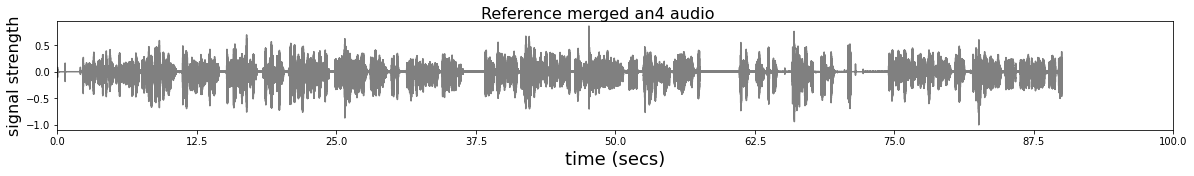

In [7]:
import IPython
import matplotlib.pyplot as plt
import numpy as np
import librosa

sr = 16000
signal, sr = librosa.load(an4_audio,sr=sr) 

fig,ax = plt.subplots(1,1)
fig.set_figwidth(20)
fig.set_figheight(2)
plt.plot(np.arange(len(signal)),signal,'gray')
fig.suptitle('Reference merged an4 audio', fontsize=16)
plt.xlabel('time (secs)', fontsize=18)
ax.margins(x=0)
plt.ylabel('signal strength', fontsize=16);
a,_ = plt.xticks();plt.xticks(a,a/sr);

IPython.display.Audio(an4_audio)

We would use [pyannote_metrics](https://pyannote.github.io/pyannote-metrics/) for visualization and score calculation purposes. Hence all the labels in rttm formats would eventually be converted to pyannote objects, we created two helper functions rttm_to_labels (for NeMo intermediate processing) and labels_to_pyannote_object for scoring and visualization format

In [8]:
from nemo.collections.asr.parts.utils.speaker_utils import rttm_to_labels, labels_to_pyannote_object

Let's load ground truth RTTM labels and view the reference Annotation timestamps visually

In [9]:
# view the sample rttm file
!cat {an4_rttm}

SPEAKER multispeaker_session_0 1   2.031   5.660 <NA> <NA> 1363 <NA> <NA>
SPEAKER multispeaker_session_0 1   7.851   2.930 <NA> <NA> 1363 <NA> <NA>
SPEAKER multispeaker_session_0 1   11.021   3.620 <NA> <NA> 1363 <NA> <NA>
SPEAKER multispeaker_session_0 1   14.911   3.130 <NA> <NA> 1363 <NA> <NA>
SPEAKER multispeaker_session_0 1   18.251   2.220 <NA> <NA> 1363 <NA> <NA>
SPEAKER multispeaker_session_0 1   20.561   3.790 <NA> <NA> 1363 <NA> <NA>
SPEAKER multispeaker_session_0 1   7.260   0.829 <NA> <NA> 7794 <NA> <NA>
SPEAKER multispeaker_session_0 1   24.619   1.190 <NA> <NA> 7794 <NA> <NA>
SPEAKER multispeaker_session_0 1   25.472   4.230 <NA> <NA> 2911 <NA> <NA>
SPEAKER multispeaker_session_0 1   29.702   1.215 <NA> <NA> 2911 <NA> <NA>
SPEAKER multispeaker_session_0 1   31.142   5.440 <NA> <NA> 2911 <NA> <NA>
SPEAKER multispeaker_session_0 1   38.066   2.390 <NA> <NA> 2911 <NA> <NA>
SPEAKER multispeaker_session_0 1   40.625   2.731 <NA> <NA> 2911 <NA> <NA>
SPEAKER multispeaker_session

['2.031 7.691000000000001 1363', '7.851 10.781 1363', '11.021 14.641000000000002 1363', '14.911 18.041 1363', '18.251 20.471 1363', '20.561 24.351 1363', '7.26 8.089 7794', '24.619 25.809 7794', '25.472 29.702 2911', '29.702 30.917 2911', '31.142 36.582 2911', '38.066 40.456 2911', '40.625 43.356 2911', '39.182 41.302 6000', '41.712 45.932 6000', '46.09 48.59 2911', '47.386 50.846000000000004 7794', '50.976 52.006 7794', '52.294 54.903999999999996 2911', '52.314 53.194 7794', '54.35 54.870000000000005 1363', '55.034 55.854 6000', '55.679 56.159 7794', '55.854 57.044 6000', '57.123 57.632999999999996 7794', '60.925 62.175 1363', '62.475 63.535000000000004 1363', '65.825 67.86500000000001 1363', '68.275 69.78500000000001 1363', '70.665 71.135 1363', '63.412 64.692 2911', '65.672 66.52199999999999 2911', '74.282 80.142 6000', '80.322 81.312 6000', '81.756 82.746 7794', '81.995 83.355 2911', '82.809 84.65899999999999 7794', '84.699 88.619 7794', '88.639 89.454 7794', '89.454 90.0 2911']


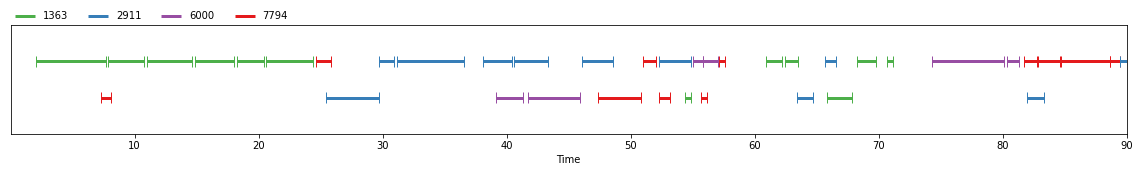

In [10]:
labels = rttm_to_labels(an4_rttm)
reference = labels_to_pyannote_object(labels)
print(labels)
reference

Speaker Diarization scripts commonly expects following arguments:
1. manifest_filepath : Path to manifest file containing json lines of format: {'audio_filepath': /path/to/audio_file, 'offset': 0, 'duration':None, 'label': 'infer', 'text': '-', 'num_speakers': None, 'rttm_filepath': /path/to/rttm/file, 'uem_filepath'='/path/to/uem/filepath'}
2. out_dir : directory where outputs and intermediate files are stored. 
3. oracle_vad: If this is true then we extract speech activity labels from rttm files, if False then either 
4. vad.model_path or external_manifestpath containing speech activity labels has to be passed. 

Mandatory fields are audio_filepath, offset, duration, label and text. For the rest if you would like to evaluate with known number of speakers pass the value else None. If you would like to score the system with known rttms then that should be passed as well, else None. uem file is used to score only part of your audio for evaluation purposes, hence pass if you would like to evaluate on it else None.


**Note** we expect audio and corresponding RTTM have **same base name** and the name should be **unique**. 

For eg: if audio file name is **test_an4**.wav, if provided we expect corresponding rttm file name to be **test_an4**.rttm (note the matching **test_an4** base name)


Lets create manifest with the an4 audio and rttm available. If you have more than one files you may also use the script `pathfiles_to_diarize_manifest.py` to generate manifest file from list of audio files and optionally rttm files 

In [21]:
# Create a manifest for input with below format. 
# {'audio_filepath': /path/to/audio_file, 'offset': 0, 'duration':None, 'label': 'infer', 'text': '-', 
# 'num_speakers': None, 'rttm_filepath': /path/to/rttm/file, 'uem_filepath'='/path/to/uem/filepath'}
import json
meta = {
    'audio_filepath': an4_audio, 
    'offset': 0, 
    'duration':None, 
    'label': 'infer', 
    'text': '-', 
    'num_speakers': 4, 
    'rttm_filepath': an4_rttm, 
    'uem_filepath' : None
}
with open('data/input_manifest.json','w') as fp:
    json.dump(meta,fp)
    fp.write('\n')

!cat data/input_manifest.json

output_dir = os.path.join(ROOT, 'oracle_vad')
os.makedirs(output_dir,exist_ok=True)

{"audio_filepath": "/home/chooper/projects/chooper_dl_msdiar/NeMo/tutorials/speaker_tasks/data/multispeaker_session_0.wav", "offset": 0, "duration": null, "label": "infer", "text": "-", "num_speakers": 4, "rttm_filepath": "/home/chooper/projects/chooper_dl_msdiar/NeMo/tutorials/speaker_tasks/data/multispeaker_session_0.rttm", "uem_filepath": null}


# ORACLE-VAD DIARIZATION

Oracle-vad diarization is to compute speaker embeddings from known speech label timestamps rather than depending on VAD output. This step can also be used to run speaker diarization with rttms generated from any external VAD, not just VAD model from NeMo.

For it, the first step is to start converting reference audio rttm(vad) time stamps to oracle manifest file. This manifest file would be sent to our speaker diarizer to extract embeddings.

This is just an argument in our config, and system automatically computes oracle manifest based on the rttms provided through input manifest file

Our config file is based on [hydra](https://hydra.cc/docs/intro/). 
With hydra config, we ask users to provide values to variables that were filled with **???**, these are mandatory fields and scripts expect them for successful runs. And notice some variables were filled with **null** are optional variables. Those could be provided if needed but are not mandatory.

In [22]:
from omegaconf import OmegaConf
MODEL_CONFIG = os.path.join(data_dir,'offline_diarization.yaml')
if not os.path.exists(MODEL_CONFIG):
    config_url = "https://raw.githubusercontent.com/NVIDIA/NeMo/main/examples/speaker_tasks/diarization/conf/offline_diarization.yaml"
    MODEL_CONFIG = wget.download(config_url,data_dir)

config = OmegaConf.load(MODEL_CONFIG)
print(OmegaConf.to_yaml(config))

name: ClusterDiarizer
num_workers: 4
sample_rate: 16000
batch_size: 64
diarizer:
  manifest_filepath: ???
  out_dir: ???
  oracle_vad: false
  collar: 0.25
  ignore_overlap: true
  vad:
    model_path: null
    external_vad_manifest: null
    parameters:
      window_length_in_sec: 0.15
      shift_length_in_sec: 0.01
      smoothing: median
      overlap: 0.875
      onset: 0.4
      offset: 0.7
      pad_onset: 0.05
      pad_offset: -0.1
      min_duration_on: 0.2
      min_duration_off: 0.2
      filter_speech_first: true
  speaker_embeddings:
    model_path: ???
    parameters:
      window_length_in_sec: 1.5
      shift_length_in_sec: 0.75
      multiscale_weights: null
      save_embeddings: false
  clustering:
    parameters:
      oracle_num_speakers: false
      max_num_speakers: 20
      enhanced_count_thres: 80
      max_rp_threshold: 0.25
      sparse_search_volume: 30
      maj_vote_spk_count: false



Now we can perform speaker diarization based on timestamps generated from ground truth rttms rather than generating through VAD

In [23]:
pretrained_speaker_model='titanet_large'
config.diarizer.manifest_filepath = 'data/input_manifest.json'
config.diarizer.out_dir = output_dir # Directory to store intermediate files and prediction outputs

config.diarizer.speaker_embeddings.model_path = pretrained_speaker_model
config.diarizer.speaker_embeddings.parameters.window_length_in_sec = 1.5
config.diarizer.speaker_embeddings.parameters.shift_length_in_sec = 0.75
config.diarizer.oracle_vad = True # ----> ORACLE VAD 
config.diarizer.clustering.parameters.oracle_num_speakers = True

In [14]:
from nemo.collections.asr.models import ClusteringDiarizer
oracle_model = ClusteringDiarizer(cfg=config)

[NeMo I 2022-08-08 12:04:37 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-08-08 12:04:37 cloud:56] Found existing object /home/chooper/.cache/torch/NeMo/NeMo_1.10.0rc0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-08-08 12:04:37 cloud:62] Re-using file from: /home/chooper/.cache/torch/NeMo/NeMo_1.10.0rc0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-08-08 12:04:37 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-08-08 12:04:37 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-08-08 12:04:37 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-08-08 12:04:37 features:200] PADDING: 16
[NeMo I 2022-08-08 12:04:38 label_models:100] loss is Angular Softmax


[NeMo W 2022-08-08 12:04:38 nemo_logging:349] /home/chooper/anaconda3/envs/test-chooper2/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                    not been set for this class (TopKClassificationAccuracy). The property determines if `update` by
                    default needs access to the full metric state. If this is not the case, significant speedups can be
                    achieved and we recommend setting this to `False`.
                    We provide an checking function
                    `from torchmetrics.utilities import check_forward_no_full_state`
                    that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                    default for now) or if `full_state_update=False` can be used safely.
                    
      warnings.warn(*args, **kwargs)
    


[NeMo I 2022-08-08 12:04:39 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /home/chooper/.cache/torch/NeMo/NeMo_1.10.0rc0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.


In [24]:
# And lets diarize
oracle_model.diarize()

[NeMo I 2022-08-08 12:06:38 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-08-08 12:06:38 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/chooper/projects/chooper_dl_msdiar/NeMo/tutorials/speaker_tasks/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-08-08 12:06:38 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-08-08 12:06:38 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-08-08 12:06:38 collections:293] # 89 files loaded accounting to # 1 labels


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.72s/it]

[NeMo I 2022-08-08 12:06:41 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0000	 MISS 0.0000	                 Diarization ER: 0.0000	, Confusion ER:0.0000
[NeMo I 2022-08-08 12:06:41 clustering_diarizer:444] Outputs are saved in /home/chooper/projects/chooper_dl_msdiar/NeMo/tutorials/speaker_tasks/oracle_vad directory


(<pyannote.metrics.diarization.DiarizationErrorRate at 0x7f50c3ed32e0>,
 {'multispeaker_session_0': {'speaker_0': '2911',
   'speaker_1': '1363',
   'speaker_2': '7794',
   'speaker_3': '6000'}})

With DER 0 -> means it clustered speaker embeddings correctly. Let's view 

In [26]:
!cat {output_dir}/pred_rttms/multispeaker_session_0.rttm

SPEAKER multispeaker_session_0 1   2.031   8.750 <NA> <NA> speaker_1 <NA> <NA>
SPEAKER multispeaker_session_0 1   11.021   3.620 <NA> <NA> speaker_1 <NA> <NA>
SPEAKER multispeaker_session_0 1   14.911   3.130 <NA> <NA> speaker_1 <NA> <NA>
SPEAKER multispeaker_session_0 1   18.251   2.220 <NA> <NA> speaker_1 <NA> <NA>
SPEAKER multispeaker_session_0 1   20.561   3.790 <NA> <NA> speaker_1 <NA> <NA>
SPEAKER multispeaker_session_0 1   24.619   1.125 <NA> <NA> speaker_2 <NA> <NA>
SPEAKER multispeaker_session_0 1   25.744   5.173 <NA> <NA> speaker_0 <NA> <NA>
SPEAKER multispeaker_session_0 1   31.142   5.440 <NA> <NA> speaker_0 <NA> <NA>
SPEAKER multispeaker_session_0 1   38.066   1.125 <NA> <NA> speaker_0 <NA> <NA>
SPEAKER multispeaker_session_0 1   39.191   1.500 <NA> <NA> speaker_3 <NA> <NA>
SPEAKER multispeaker_session_0 1   40.691   1.500 <NA> <NA> speaker_0 <NA> <NA>
SPEAKER multispeaker_session_0 1   42.191   3.741 <NA> <NA> speaker_3 <NA> <NA>
SPEAKER multispeaker_session_0 1   46.090

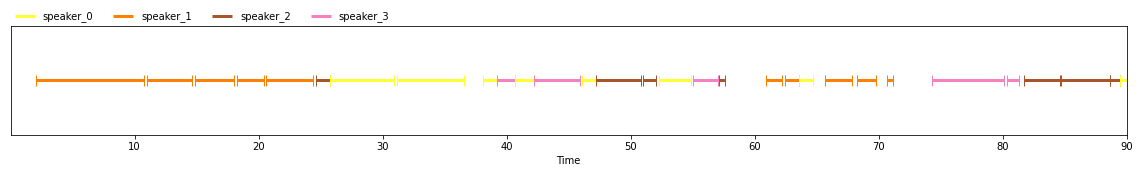

In [27]:
pred_labels = rttm_to_labels(output_dir+'/pred_rttms/multispeaker_session_0.rttm')
hypothesis = labels_to_pyannote_object(pred_labels)
hypothesis

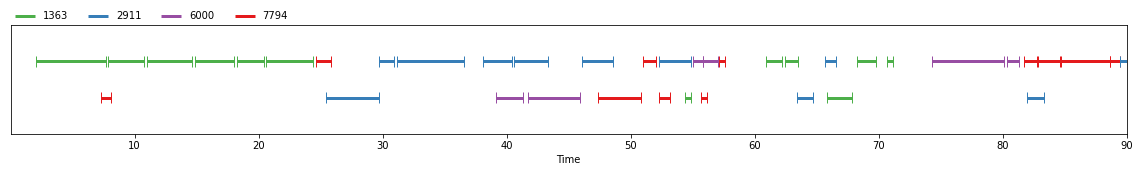

In [20]:
reference

# VAD DIARIZATION

In this method we compute VAD time stamps using NeMo VAD model on input manifest file and then use these time stamps of speech label to find speaker embeddings followed by clustering them into num of speakers

Before we proceed let's look at the speaker diarization config, which we would be depending up on for vad computation
and speaker embedding extraction

In [ ]:
print(OmegaConf.to_yaml(config))

As can be seen most of the variables in config are self explanatory 
with VAD variables under vad section and speaker related variables under speaker embeddings section. 

To perform VAD based diarization we can ignore `oracle_vad_manifest` in `speaker_embeddings` section for now and needs to fill up the rest. We also needs to provide pretrained `model_path` of vad and speaker embeddings .nemo models

In [ ]:
pretrained_vad = 'vad_marblenet'
pretrained_speaker_model = 'titanet_large'

Note in this tutorial, we use the VAD model MarbleNet-3x2 introduced and published in [ICASSP MarbleNet](https://arxiv.org/pdf/2010.13886.pdf). You might need to tune on dev set similar to your dataset if you would like to improve the performance.

And the speakerNet-M-Diarization model achieves 7.3% confusion error rate on CH109 set with oracle vad. This model is trained on voxceleb1, voxceleb2, Fisher, SwitchBoard datasets. So for more improved performance specific to your dataset, finetune speaker verification model with a devset similar to your test set.

It is recommended to set `num_workers=1` since using mulitprocessing package in Jupyter Notebook environment might cause freezing issues. For sizable data, run speaker diarization using the scripts in `NeMo/examples/speaker_tasks/` setting `num_workers` larger than 1 in the configurations.

In [ ]:
config.num_workers = 1 # Workaround for multiprocessing hanging with ipython issue 

output_dir = os.path.join(ROOT,'outputs')
config.diarizer.manifest_filepath = 'data/input_manifest.json'
config.diarizer.out_dir = output_dir #Directory to store intermediate files and prediction outputs

config.diarizer.speaker_embeddings.model_path = pretrained_speaker_model
config.diarizer.speaker_embeddings.parameters.window_length_in_sec = 1.5
config.diarizer.speaker_embeddings.parameters.shift_length_in_sec = 0.75
config.diarizer.oracle_vad = False # compute VAD provided with model_path to vad config
config.diarizer.clustering.parameters.oracle_num_speakers=True

#Here we use our inhouse pretrained NeMo VAD 
config.diarizer.vad.model_path = pretrained_vad
config.diarizer.vad.window_length_in_sec = 0.15
config.diarizer.vad.shift_length_in_sec = 0.01
config.diarizer.vad.parameters.onset = 0.8 
config.diarizer.vad.parameters.offset = 0.6
config.diarizer.vad.parameters.min_duration_on = 0.1
config.diarizer.vad.parameters.min_duration_off = 0.4

Now that we passed all the variables we needed lets initialize the clustering model with above config

In [ ]:
from nemo.collections.asr.models import ClusteringDiarizer
sd_model = ClusteringDiarizer(cfg=config)

And Diarize with single line of code

In [ ]:
sd_model.diarize()

As can be seen, we first performed VAD, then with the timestamps created in `{output_dir}/vad_outputs` by VAD we calculated speaker embeddings (`{output_dir}/speaker_outputs/embeddings/`) which are then clustered using spectral clustering. 

To generate VAD predicted time step. We perform VAD inference to have frame level prediction &#8594; (optional: use decision smoothing) &#8594; given `threshold`,  write speech segment to RTTM-like time stamps manifest.

we use vad decision smoothing (87.5% overlap median) as described [here](https://github.com/NVIDIA/NeMo/blob/stable/nemo/collections/asr/parts/utils/vad_utils.py)

you can also tune the threshold on your dev set. Use this provided [script](https://github.com/NVIDIA/NeMo/blob/stable/scripts/voice_activity_detection/vad_tune_threshold.py)

In [ ]:
# VAD predicted time stamps
# you can also use single threshold(=onset=offset) for binarization and plot here
from nemo.collections.asr.parts.utils.vad_utils import plot
plot(
    an4_audio,
    'outputs/vad_outputs/overlap_smoothing_output_median_0.875/an4_diarize_test.median', 
    an4_rttm,
    per_args = config.diarizer.vad.parameters, #threshold
    ) 

print(f"postprocessing_params: {config.diarizer.vad.parameters}")

Predicted outputs are written to `output_dir/pred_rttms` and see how we predicted along with VAD prediction

In [ ]:
!cat outputs/pred_rttms/an4_diarize_test.rttm

In [ ]:
pred_labels = rttm_to_labels('outputs/pred_rttms/an4_diarize_test.rttm')
hypothesis = labels_to_pyannote_object(pred_labels)
hypothesis

In [ ]:
reference

# Storing and Restoring models

Now we can save the whole config and model parameters in a single .nemo and restore from it anytime.

In [ ]:
oracle_model.save_to(os.path.join(output_dir,'diarize.nemo'))

Restore from saved model

In [ ]:
del oracle_model
import nemo.collections.asr as nemo_asr
restored_model = nemo_asr.models.ClusteringDiarizer.restore_from(os.path.join(output_dir,'diarize.nemo'))